# Aprendizaje Profundo - Clase 4



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Dataset


In [2]:
df = pd.read_csv("/content/drive/MyDrive/Trabajo AP/class_7_wine_dataset_v2.csv")

In [3]:
# Type es tipo categórica, transformamos con One Hot Encoding
type_dummies = pd.get_dummies(df['type'], prefix="type")
df = pd.concat([df,type_dummies], axis = 1)

In [4]:
# Transformamos el problema en clasificación binaria
df["quality_label"] = df["quality"].apply(lambda q:0 if q<=6 else 1)

In [5]:
# Como tenemos pocos nan, borramos las filas donde hay nan y trabajamos con un dataset completo
ds = df[df.isna().sum(axis = 1) == 0]

In [6]:
# Guardo vendor_id para modelo con embeddings
vendor_id = ds['vendor_id']
# Recordar que debo borrar del dataset de entrada mi columna de salida!
x = ds.drop(['Unnamed: 0','type','vendor_id','quality','quality_label'], axis=1) 
y = ds['quality_label']

In [7]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6463 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6463 non-null   float64
 1   volatile acidity      6463 non-null   float64
 2   citric acid           6463 non-null   float64
 3   residual sugar        6463 non-null   float64
 4   chlorides             6463 non-null   float64
 5   free sulfur dioxide   6463 non-null   float64
 6   total sulfur dioxide  6463 non-null   float64
 7   density               6463 non-null   float64
 8   pH                    6463 non-null   float64
 9   sulphates             6463 non-null   float64
 10  alcohol               6463 non-null   float64
 11  type_red              6463 non-null   uint8  
 12  type_white            6463 non-null   uint8  
dtypes: float64(11), uint8(2)
memory usage: 618.5 KB


In [8]:
# Normalizacion
x = x.to_numpy()
y = y.to_numpy()
x_norm = (x - np.min(x, axis=0)) / (np.max(x, axis=0 ) - np.min(x, axis=0))

In [9]:
# Divido el dataset
idx = np.random.permutation(x_norm.shape[0])
train_idx = idx[0:int(0.85*len(idx))]
valid_idx = idx[int(0.85*len(idx)):]

train_x = x_norm[train_idx]
train_y = y[train_idx]
valid_x = x_norm[valid_idx]
valid_y = y[valid_idx]

n_train = train_x.shape[0]
n_valid = valid_x.shape[0]

## Pytorch

### Modelo sin embeddings

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics

In [11]:
# Pytorch necesita de una clase de dataset que extienda de torch.utils.data.Dataset
# Esta clase dataset debe sobreescribir los métodos init, len y getitem
class MyDataset(Dataset):

  #__init__ guarda el dataset en una variable de clase
  def __init__(self, x, y):
    self.x = x
    self.y = y

  # __len__ define el comportamiento de la función len() sobre el objeto
  def __len__(self):
    return self.x.shape[0]

  # __getitem__ define el comportamiento de los []
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [12]:
# Creo el dataset de entrenamiento
train_ds = MyDataset(train_x, train_y)
# Creo el dataset de validación
valid_ds = MyDataset(valid_x, valid_y)

In [13]:
# Pytorch utiliza DataLoader para entregar los dataset de a batches
train_dataloader = DataLoader(train_ds, batch_size = 64, shuffle= True)
valid_dataloader = DataLoader(valid_ds, batch_size=64)

In [14]:
# Arquitectura
class NNet(torch.nn.Module):

  def __init__(self):
    # Defino la arquitectura de la red
    super().__init__()
    self.linear_1 = torch.nn.Linear(in_features=13, out_features=200, bias=True)
    self.relu_1 = torch.nn.ReLU()
    self.linear_2 = torch.nn.Linear(in_features = 200, out_features=100, bias=True)
    self.relu_2 = torch.nn.ReLU()
    self.output = torch.nn.Linear(in_features = 100, out_features= 1, bias=True)

  def forward(self, x):
    # Defino el cálculo del paso forward
    x = self.linear_1(x)
    x = self.relu_1(x)
    x = self.linear_2(x)
    x = self.relu_2(x)
    x = self.output(x)
    return x

In [15]:
# Instanciamos la red
nnet = NNet()

In [16]:
# Función de pérdida y optimizador
loss_function = torch.nn.BCEWithLogitsLoss(reduction='sum')
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.01)

In [17]:
device = "cpu"
if torch.cuda.is_available():
  device = "cuda:0"

device

'cpu'

In [18]:
# Copio la red neuronal al dispositivo donde entrene la red neuronal
nnet = nnet.to(device)

In [19]:
# Algoritmo Mini-batch

# cantidad de epochs
epochs = 100

train_loss_by_epoch=[]
valid_loss_by_epoch=[]

# Doble loop algoritmo Mini-Batch
for epoch in range(epochs):
  
  ############################################
  ## Entrenamiento
  ############################################
  nnet.train(True)

  epoch_loss = 0
  epoch_y_hat = []
  epoch_y = []
  
  for i,data in enumerate(train_dataloader):
    # Obtengo los datos del batch de entrenamiento
    x_batch, y_batch = data
    # Copio el batch al dispositivo donde entreno la red neuronal
    x_batch = x_batch.to(device).float()
    y_batch = y_batch.to(device).float().reshape(-1, 1)

    # Paso forward
    # Limpio optimizer para empezar un nuevo cálculo de gradiente
    optimizer.zero_grad()
    nnet_output = nnet(x_batch)
    y_batch_hat = torch.sigmoid(nnet_output)
    
    # Calculo el loss
    loss = loss_function(nnet_output, y_batch)

    # Backpropagation
    loss.backward()

    # Actualizar los parámetros
    optimizer.step()

    # Almaceno los valores reales y mis predicciones para cálcular las métricas
    epoch_y += list(y_batch.detach().cpu().numpy())
    epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())
    # Acumulo la loss del batch
    epoch_loss = epoch_loss + loss.item()

  # Calculo la media de la loss
  epoch_loss = epoch_loss / n_train
  # Almaceno la loss de la epoch para graficar
  train_loss_by_epoch.append(epoch_loss)
  # Cálculo la métrica de la epoch
  accuracy = metrics.accuracy_score(epoch_y, [j>=0.5 for j in epoch_y_hat])

  ############################################
  ## Validación
  ############################################
  # Desactivo el cálculo de gradiente para validación
  nnet.train(False)

  valid_epoch_loss = 0
  valid_epoch_y_hat = []
  valid_epoch_y = []

  for i,data in enumerate(valid_dataloader):
    # Obtengo los datos del batch de validación
    x_batch, y_batch = data
    # Copio el batch al dispositivo donde entreno la red neuronal
    x_batch = x_batch.to(device).float()
    y_batch = y_batch.to(device).float().reshape(-1, 1)

    # Paso forward
    nnet_output = nnet(x_batch)
    y_batch_hat = torch.sigmoid(nnet_output)
    
    # Calculo el loss
    loss = loss_function(nnet_output, y_batch)

    # En validación no hago backpropagation!!

    # Almaceno los valores reales y mis predicciones para cálcular las métricas
    valid_epoch_y += list(y_batch.detach().cpu().numpy())
    valid_epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())
    # Acumulo la loss del batch
    valid_epoch_loss = valid_epoch_loss + loss.item()

  # Calculo la media de la loss
  valid_epoch_loss = valid_epoch_loss / n_valid
  # Almaceno la loss de la epoch para graficar
  valid_loss_by_epoch.append(valid_epoch_loss)
  # Cálculo la métrica de la epoch
  valid_accuracy = metrics.accuracy_score(valid_epoch_y, [j>=0.5 for j in valid_epoch_y_hat])

  ############################################
  ## Impresión de resultados por epoch
  ############################################
  print(f" Epoch {epoch} | " \
        f"Train/Valid loss: {epoch_loss:.3f} / {valid_epoch_loss:.3f} | " \
        f"Train/Valid accuracy: {accuracy:.3f} / {valid_accuracy:.3f}")

 Epoch 0 | Train/Valid loss: 0.429 / 0.435 | Train/Valid accuracy: 0.808 / 0.780
 Epoch 1 | Train/Valid loss: 0.395 / 0.423 | Train/Valid accuracy: 0.825 / 0.792
 Epoch 2 | Train/Valid loss: 0.390 / 0.428 | Train/Valid accuracy: 0.824 / 0.798
 Epoch 3 | Train/Valid loss: 0.385 / 0.403 | Train/Valid accuracy: 0.825 / 0.805
 Epoch 4 | Train/Valid loss: 0.380 / 0.399 | Train/Valid accuracy: 0.825 / 0.798
 Epoch 5 | Train/Valid loss: 0.378 / 0.403 | Train/Valid accuracy: 0.827 / 0.805
 Epoch 6 | Train/Valid loss: 0.375 / 0.427 | Train/Valid accuracy: 0.825 / 0.805
 Epoch 7 | Train/Valid loss: 0.377 / 0.394 | Train/Valid accuracy: 0.826 / 0.802
 Epoch 8 | Train/Valid loss: 0.366 / 0.405 | Train/Valid accuracy: 0.823 / 0.795
 Epoch 9 | Train/Valid loss: 0.366 / 0.402 | Train/Valid accuracy: 0.827 / 0.800
 Epoch 10 | Train/Valid loss: 0.366 / 0.399 | Train/Valid accuracy: 0.833 / 0.804
 Epoch 11 | Train/Valid loss: 0.365 / 0.409 | Train/Valid accuracy: 0.831 / 0.808
 Epoch 12 | Train/Valid lo

Text(0, 0.5, 'BCE')

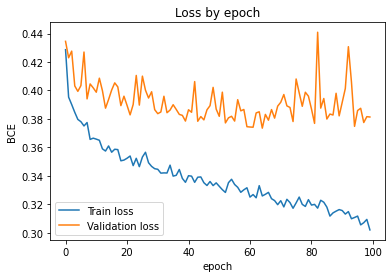

In [20]:
# Grafica loss por epoch
fig, ax1= plt.subplots(1,1)
ax1.plot(train_loss_by_epoch, label="Train loss")
ax1.plot(valid_loss_by_epoch, label="Validation loss")
ax1.legend()
ax1.set_title("Loss by epoch")
ax1.set_xlabel("epoch")
ax1.set_ylabel("BCE")

### Modelo con Embeddings

In [21]:
# No puedo utilizar OHE con vendor_id
len(vendor_id.unique())

500

In [22]:
# Los vendor id no son consecutivos
vendor_id.unique()

array([369, 361, 354, 325, 375, 380, 312, 301, 355, 290, 210, 260, 421,
       248, 416, 383, 277, 586, 413, 559, 234, 317, 318, 353, 305, 470,
       381, 347, 396, 243, 232, 200, 358, 256, 374, 384, 357, 393, 462,
       143, 252, 329, 257, 389, 469, 459, 335, 334, 359, 306, 323, 339,
       209, 379, 373, 203, 464, 276, 233, 288, 230, 331, 536, 254, 401,
       478, 247, 348, 321, 206, 316, 268, 365, 322, 261, 367, 215, 438,
       496, 482, 399, 417, 270, 214, 241, 263, 274, 326, 286, 275, 279,
       132, 385, 307, 218, 223, 352, 308, 471, 461, 269, 449, 265, 228,
       445, 299, 345, 320, 313, 190, 466, 300, 409, 372, 398, 227, 440,
       573, 578, 486, 244, 212, 294, 497, 262, 392, 150, 196, 239, 194,
       250, 351, 287, 245, 272, 506, 180, 390, 253, 282, 222, 235, 264,
       266, 292, 157, 137, 415, 324, 240, 258, 350, 284, 340, 207, 182,
       314, 338, 433, 201, 432, 311, 437, 441, 439, 105,  72,  80, 360,
       403, 114, 273, 395, 309, 291, 249, 140, 518, 562, 152, 22

In [23]:
# Transformo vendor id a indices (idx) consecutivos para utilizar embeddings
vendor_id_to_idx = {value:i for i,value in enumerate(vendor_id.unique())}

In [24]:
# Vector de vendor_idx en el dataset
vendor_idx = np.array([vendor_id_to_idx[value] for value in vendor_id])

In [25]:
# Divido el vector vendor_idx en entrenamiento y validación
vendor_idx_train = vendor_idx[train_idx]
vendor_idx_valid = vendor_idx[valid_idx]

In [26]:
# Clase Dataset de Pytorch con embeddings
class MyDatasetWithEmbddings(Dataset):

  def __init__(self, x, vendor_idx, y):
    self.x = x
    self.vendor_idx = vendor_idx
    self.y = y

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    return self.x[idx], self.vendor_idx[idx], self.y[idx]

In [27]:
train_ds_embeddings = MyDatasetWithEmbddings(train_x, vendor_idx_train, train_y)
valid_ds_embeddings = MyDatasetWithEmbddings(valid_x, vendor_idx_valid, valid_y)

In [28]:
train_dataloader_emb = DataLoader(train_ds_embeddings, batch_size =64, shuffle= True)
valid_dataloader_emb = DataLoader(valid_ds_embeddings, batch_size=64)

In [29]:
# Arquitectura con embeddings
class NNetWithEmbeddings(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.embeddings = torch.nn.Embedding(num_embeddings=500, embedding_dim=8)
    self.linear_1 = torch.nn.Linear(in_features=13+8, out_features=200, bias=True)
    self.relu_1 = torch.nn.ReLU()
    self.linear_2 = torch.nn.Linear(in_features = 200, out_features=100, bias=True)
    self.relu_2 = torch.nn.ReLU()
    self.output = torch.nn.Linear(in_features = 100, out_features= 1, bias=True)

  def forward(self, x, vendor_idx):
    embeddings_outputs = self.embeddings(vendor_idx)
    x = torch.cat([x, embeddings_outputs], dim=1)
    x = self.linear_1(x)
    x = self.relu_1(x)
    x = self.linear_2(x)
    x = self.relu_2(x)
    x = self.output(x)
    return x

In [30]:
nnnetWithEmbeddings = NNetWithEmbeddings()
nnnetWithEmbeddings = nnnetWithEmbeddings.to(device)

In [31]:
loss_function = torch.nn.BCEWithLogitsLoss(reduction='sum')
# Optimizador con regularización L2 (parámetro weight_decay)
optimizer = torch.optim.Adam(nnnetWithEmbeddings.parameters(), lr=0.001, weight_decay=0.01) 

In [32]:
# Mini-Batch

# cantidad de epochs
epochs = 100

train_loss_by_epoch=[]
valid_loss_by_epoch=[]

# Doble loop algoritmo Mini-Batch
for epoch in range(epochs):
  
  ############################################
  ## Entrenamiento
  ############################################
  nnnetWithEmbeddings.train(True)

  epoch_loss = 0
  epoch_y_hat = []
  epoch_y = []
  
  for i,data in enumerate(train_dataloader_emb):
    # Obtengo los datos del batch de entrenamiento
    x_batch, embed_batch, y_batch = data
    # Copio el batch al dispositivo donde entreno la red neuronal
    x_batch = x_batch.to(device).float()
    embed_batch = embed_batch.to(device).int()
    y_batch = y_batch.to(device).float().reshape(-1, 1)

    # Paso forward
    # Limpio optimizer para empezar un nuevo cálculo de gradiente
    optimizer.zero_grad()
    nnet_output = nnnetWithEmbeddings(x_batch, embed_batch)
    y_batch_hat = torch.sigmoid(nnet_output)
    
    # Calculo el loss
    loss = loss_function(nnet_output, y_batch)

    # Backpropagation
    loss.backward()

    # Actualizar los parámetros
    optimizer.step()

    # Almaceno los valores reales y mis predicciones para cálcular las métricas
    epoch_y += list(y_batch.detach().cpu().numpy())
    epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())
    # Acumulo la loss del batch
    epoch_loss = epoch_loss + loss.item()

  # Calculo la media de la loss
  epoch_loss = epoch_loss / n_train
  # Almaceno la loss de la epoch para graficar
  train_loss_by_epoch.append(epoch_loss)
  # Cálculo la métrica de la epoch
  accuracy = metrics.accuracy_score(epoch_y, [j>=0.5 for j in epoch_y_hat])

  ############################################
  ## Validación
  ############################################
  # Desactivo el cálculo de gradiente para validación
  nnnetWithEmbeddings.train(False)

  valid_epoch_loss = 0
  valid_epoch_y_hat = []
  valid_epoch_y = []

  for i,data in enumerate(valid_dataloader_emb):
    # Obtengo los datos del batch de validación
    x_batch, embed_batch, y_batch = data
    # Copio el batch al dispositivo donde entreno la red neuronal
    x_batch = x_batch.to(device).float()
    embed_batch = embed_batch.to(device).int()
    y_batch = y_batch.to(device).float().reshape(-1, 1)

    # Paso forward
    nnet_output = nnnetWithEmbeddings(x_batch, embed_batch)
    y_batch_hat = torch.sigmoid(nnet_output)
    
    # Calculo el loss
    loss = loss_function(nnet_output, y_batch)

    # En validación no hago backpropagation!!

    # Almaceno los valores reales y mis predicciones para cálcular las métricas
    valid_epoch_y += list(y_batch.detach().cpu().numpy())
    valid_epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())
    # Acumulo la loss del batch
    valid_epoch_loss = valid_epoch_loss + loss.item()

  # Calculo la media de la loss
  valid_epoch_loss = valid_epoch_loss / n_valid
  # Almaceno la loss de la epoch para graficar
  valid_loss_by_epoch.append(valid_epoch_loss)
  # Cálculo la métrica de la epoch
  valid_accuracy = metrics.accuracy_score(valid_epoch_y, [j>=0.5 for j in valid_epoch_y_hat])

  ############################################
  ## Impresión de resultados por epoch
  ############################################
  print(f" Epoch {epoch} | " \
        f"Train/Valid loss: {epoch_loss:.3f} / {valid_epoch_loss:.3f} | " \
        f"Train/Valid accuracy: {accuracy:.3f} / {valid_accuracy:.3f}")

 Epoch 0 | Train/Valid loss: 0.500 / 0.475 | Train/Valid accuracy: 0.796 / 0.793
 Epoch 1 | Train/Valid loss: 0.415 / 0.396 | Train/Valid accuracy: 0.812 / 0.825
 Epoch 2 | Train/Valid loss: 0.317 / 0.302 | Train/Valid accuracy: 0.872 / 0.893
 Epoch 3 | Train/Valid loss: 0.223 / 0.229 | Train/Valid accuracy: 0.922 / 0.919
 Epoch 4 | Train/Valid loss: 0.152 / 0.172 | Train/Valid accuracy: 0.951 / 0.946
 Epoch 5 | Train/Valid loss: 0.103 / 0.135 | Train/Valid accuracy: 0.969 / 0.956
 Epoch 6 | Train/Valid loss: 0.073 / 0.110 | Train/Valid accuracy: 0.981 / 0.966
 Epoch 7 | Train/Valid loss: 0.054 / 0.093 | Train/Valid accuracy: 0.988 / 0.974
 Epoch 8 | Train/Valid loss: 0.041 / 0.083 | Train/Valid accuracy: 0.992 / 0.978
 Epoch 9 | Train/Valid loss: 0.032 / 0.074 | Train/Valid accuracy: 0.994 / 0.981
 Epoch 10 | Train/Valid loss: 0.027 / 0.074 | Train/Valid accuracy: 0.995 / 0.981
 Epoch 11 | Train/Valid loss: 0.023 / 0.060 | Train/Valid accuracy: 0.995 / 0.985
 Epoch 12 | Train/Valid lo